# Datamining

In [1]:
SEED = 26062019

test_size = 0.5 

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers
import pickle
import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


## Load data

In [5]:
df_mood = pd.read_csv(r'data/dataset_mood_smartphone.csv', sep=',', index_col=0)
print('nr of entries: ', len(df_mood))
df_mood['time'] = df_mood['time'].astype('datetime64[ns]')

df_mood.head()

nr of entries:  376912


,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


(5641, 5643, 5643, 22965, 96578, 5239, 1798, 91288, 74276, 27125, 939, 813, 5642, 7650, 19145, 2846, 939, 2487, 255)


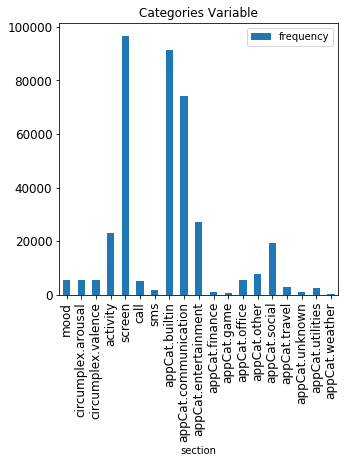

In [6]:
from collections import Counter

labels, values = zip(*Counter(df_mood['variable']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

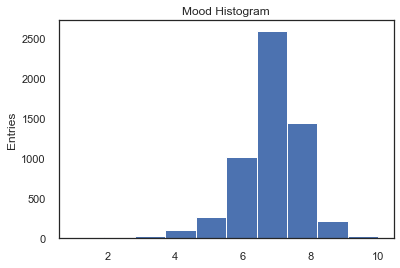

In [347]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='mood']

x = sub_mood['value']
plt.hist(x)
plt.gca().set(title='Mood Histogram', ylabel='Entries');

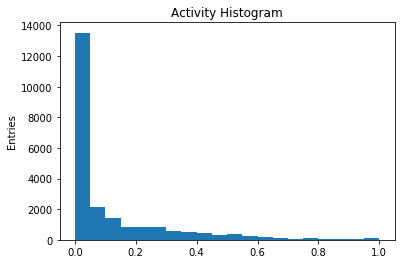

In [5]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='activity']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Activity Histogram', ylabel='Entries');

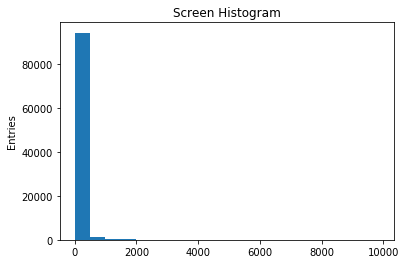

In [14]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='screen']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Screen Histogram', ylabel='Entries');

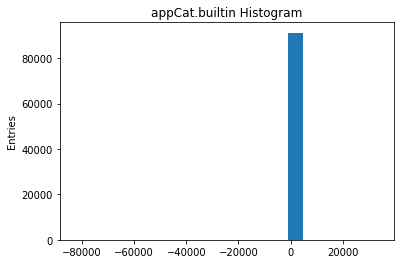

In [8]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='appCat.builtin']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.builtin Histogram', ylabel='Entries');

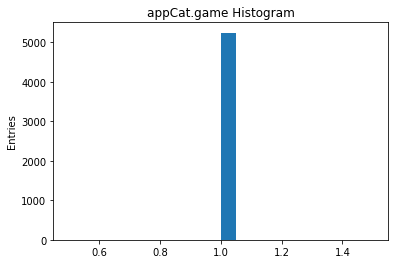

In [13]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='call']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.game Histogram', ylabel='Entries');

## Aggregate Data

### step 1: Count days since inclusion
This is an important step to prepare the data for time window aggregation.

In [8]:
from pandas import datetime
class Aggregation(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
    
    def setDF(self):
        self.df = df
        
    def getDF(self):
        return self.df
    
    def parser(self, x):
        return datetime.strptime(str(x)[:10], '%Y-%m-%d')
    
    def formatTimeSpan(self):
        """
        Translate time stamps to time in days ever since inclusion of said user
        
        Translate informational absent single observation columns 
        to meaningful frequencies. (For example: sms & calls columns)
        
        """
        cols = list(self.df.keys())
        cols.append('days')
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub, initial_date = self.countTheDays(df_sub)
            for day in range(df_sub['days'].max()):
                df_day = df_sub[df_sub['days']==day]
                nr_calls = len(df_day[df_day['variable']=='call'])
                #print(nr_calls)
                if nr_calls != 0:
                    df_calls = pd.DataFrame([pd.Series([df_day['id'].iloc[0], self.parser(df_day['time'].iloc[0]), 'total_calls', nr_calls, day])])
                    df_calls = df_calls.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    #print(df_calls)
                    
                    df_sub = pd.concat([df_sub, df_calls], axis=0)
                nr_sms = len(df_day[df_day['variable']=='sms'])
                if nr_sms != 0:
                    df_sms = pd.DataFrame([pd.Series([df_day['id'].iloc[0], df_day['time'].iloc[0], 'total_sms', nr_sms, day])])
                    df_sms = df_sms.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    df_sub = pd.concat([df_sub, df_sms], axis=0)
                if day not in list(df_sub['days'].unique()):
                    #print(day)
                    date= self.parser(initial_date) + pd.Timedelta(days=day)
                    s = pd.DataFrame([pd.Series([df_sub['id'].iloc[0],date,'mood',np.nan, day], index=cols)])
                    df_sub = pd.concat([df_sub, s], axis=0, ignore_index=True)# df_sub.append(s, ignore_index=True)
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        
    def countTheDays(self, df_sub):
        initial_date = df_sub[self.timestamp].min()
        df_sub['days'] = pd.to_datetime(df_sub[self.timestamp]).sub(initial_date).dt.days
        return df_sub, initial_date

    
def parser(x):
    #print(str(x)[:10])
    return datetime.strptime(str(x)[:10], '%Y-%m-%d')
    
df_mood['time'] = df_mood['time'].apply(lambda x : parser(x))
agg = Aggregation(df_mood, 'id', 'time', window=5)
agg.formatTimeSpan()
temp_df = agg.getDF()
temp_df.head()

C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,time,variable,value,days
0,AS14.01,2014-02-26,mood,6.0,9
1,AS14.01,2014-02-26,mood,6.0,9
2,AS14.01,2014-02-26,mood,6.0,9
3,AS14.01,2014-02-26,mood,7.0,9
4,AS14.01,2014-02-27,mood,6.0,10


In [405]:
temp_df_unstack.head()

variable,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms
0,AS14.01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,AS14.01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,AS14.01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0
3,AS14.01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
4,AS14.01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Aggregate History

### Step 1: Transform long to wide
### Step 2: Aggregate 

In [408]:
class Aggregation2(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
        
    def getFinalMood(self, row):
        #print(row['days'])
        next_day = int(row['days']) + 1
        
        subject = row['id']
        if next_day < len(self.df[self.df[self.key]==subject]):
            next_mood = self.df[((self.df[self.key]==subject)&(self.df['days']==next_day))]['mood'].iloc[0]
            # print(next_mood)
        else :
            next_mood = np.nan
        return next_mood
    
    def aggregate(self, window_size):
        # create sub df for each subject
        cols = list(self.df.keys())
        #print(cols)
        cols.append('final_mood') # add label
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub.rolling(5).agg({'activity':'mean', 'appCat.builtin':'mean', 'appCat.communication':'mean','appCat.entertainment':'mean', 
                           'appCat.other':'mean','appCat.social':'mean', 'appCat.travel':'mean', 'circumplex.arousal':'mean',  
                           'circumplex.valence':'mean',  'mood':'mean',  'screen':'mean',  'total_calls':'mean',  'total_sms':'mean'})
            df_sub['final_mood'] = df_sub['days'].copy()
            #df_sub['time'] = df_sub['days'].copy()
            #print(df_sub)
            df_sub['final_mood'] = df_sub.apply(lambda x : self.getFinalMood(x), axis=1)
            df_sub['days'] = df_sub['days'].apply(lambda x : 'day '+ str(x-window_size+1)+ ' to ' + str(x+1))
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        return
    
    def getDF(self):
        return self.df

temp_df_unstack = temp_df.groupby(['id', 'days','variable'])['value'].median().unstack('variable')
temp_df_unstack = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen',
       'total_calls', 'total_sms']]
temp_df_unstack = temp_df_unstack.reset_index(drop=False)
temp_df_unstack.to_csv(r'data/prep_temporal_raw.csv', index = False, header=True)
agg = Aggregation2(temp_df_unstack, 'id', 'time', window=5)
agg.aggregate(5)
temp_df_2 = agg.getDF()
temp_df_2.head()

C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

variable,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms,final_mood
0,AS14.01,day -4 to 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1,AS14.01,day -3 to 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,AS14.01,day -2 to 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,NaN
3,AS14.01,day -1 to 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
4,AS14.01,day 0 to 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


## Write preprocessed aggregated datasets
Two versions:
- With missing mood values or labels () (raw)
- Without missing mood values or labels
Note: we also ensure that the current mood was registered otherwise we cant compare to baseline

In [99]:
print('Nr entries with available label:', len(temp_df_2[((~temp_df_2['final_mood'].isna()) & (~temp_df_2['mood'].isna()))]))
print('Nr of entries with missing label:', len(temp_df_2[((temp_df_2['final_mood'].isna()) | (temp_df_2['mood'].isna()))]))
temp_df_2.to_csv(r'data/prep_aggregated_raw.csv', index = False, header=True)
temp_df_2[((~temp_df_2['final_mood'].isna()) & (~temp_df_2['mood'].isna()))].to_csv(r'data/prep_aggregated_noNan.csv', index = False, header=True)

1232


In [ ]:
from collections import Counter

x = temp_df_2['final_mood']
plt.hist(x, bins=10)
plt.gca().set(title='finalMood', ylabel='Entries');

(693, 217, 259, 37, 18, 5, 1, 1, 1)


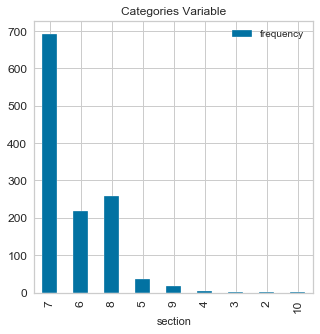

In [38]:
#df_agg[df_agg.columns[-1]].sum()
from collections import Counter

labels, values = zip(*Counter(df_agg[df_agg.columns[-1]]).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

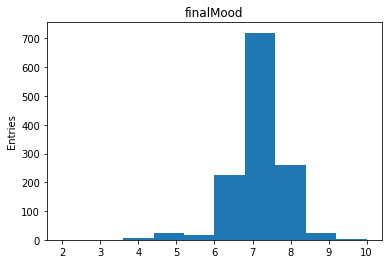

In [100]:
from collections import Counter

x = temp_df_2['final_mood']
plt.hist(x, bins=10)
plt.gca().set(title='finalMood', ylabel='Entries');

In [2]:
import pandas as pd
df_agg = pd.read_csv(r'data/prep_aggregated_noNan.csv', sep=',')
print('nr of entries: ', len(df_agg))
df_agg.head()

nr of entries:  1232


,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms,final_mood
0,AS14.01,day 5 to 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,0.5,6.0,NaN,1.0,2.0,7.0
1,AS14.01,day 27 to 32,0.008333,3.0410,27.6845,22.7870,13.6375,65.335,14.067,-0.5,0.0,6.0,31.748,NaN,NaN,7.0
2,AS14.01,day 28 to 33,0.144068,3.9040,24.6470,21.2360,10.1110,42.241,19.696,1.0,1.0,7.0,27.813,6.0,NaN,7.0
3,AS14.01,day 29 to 34,0.218487,4.0190,20.4580,46.6620,12.0540,40.275,NaN,0.0,1.0,7.0,17.975,3.0,1.0,6.0
4,AS14.01,day 30 to 35,0.055645,3.1085,19.8080,21.5865,9.0280,44.157,NaN,1.0,0.0,6.0,25.985,NaN,NaN,6.0


## missingness

In [15]:
import seaborn as sns

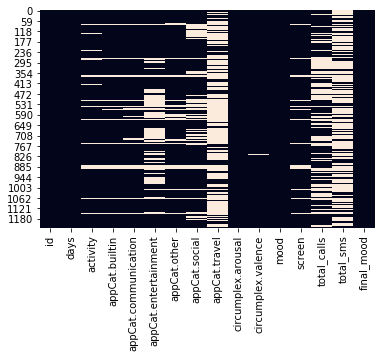

In [16]:
heatmap = sns.heatmap(df_agg.isnull(), cbar=False)
heatmap.figure.savefig("figures/missingness.png")

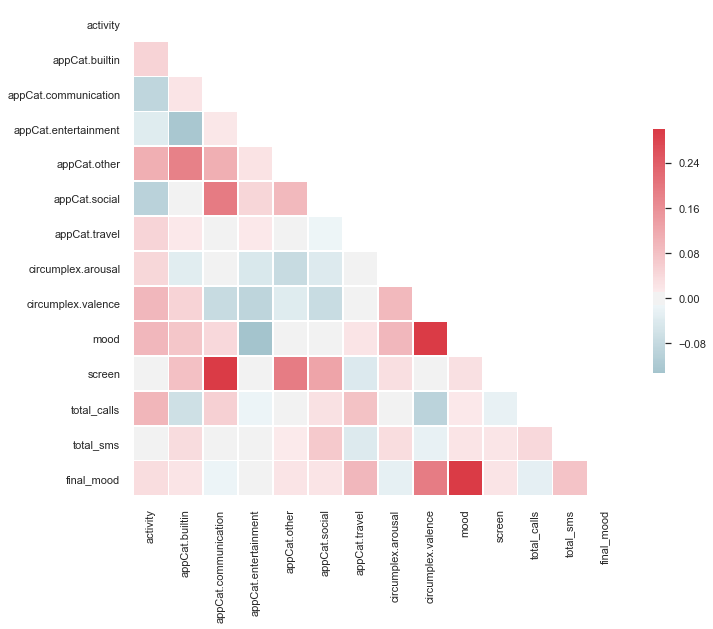

In [335]:
sns.set(style="white")

# Generate a large random dataset

# Compute the correlation matrix
corr = df_agg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.figure.savefig("figures/correlation_heatmap.png")

## Train Models

In [4]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, RobustScaler  # scale time features
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mord import LogisticIT
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier #  OneVsRestClassifier(

In [6]:
#[i for i in range(1,11)]
# Factorizing the column data
df_agg[df_agg.columns[-1]] = df_agg[df_agg.columns[-1]].astype(int)
df_agg = df_agg[((df_agg[df_agg.columns[-1]]>5) & (df_agg[df_agg.columns[-1]]<9))]
df_agg = df_agg.sort_values('final_mood')
categories = pd.Categorical(df_agg['final_mood'], categories=[i for i in range(1,11)], ordered=True)
labels, unique = pd.factorize(categories, sort=True)
df_agg['final_mood'] = labels
df_agg = df_agg.fillna(0)
# Encoded Income Range Data
df_agg['final_mood'].head()

494    0
699    0
700    0
163    0
701    0
Name: final_mood, dtype: int64

(217, 693, 259)


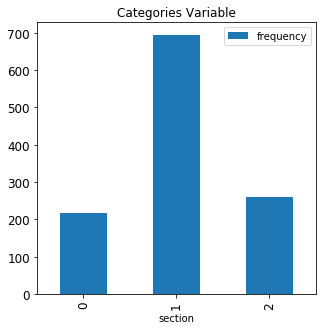

In [7]:
#df_agg[df_agg.columns[-1]].sum()
from collections import Counter

labels, values = zip(*Counter(df_agg[df_agg.columns[-1]]).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

In [51]:
SEED =12231

clf = Pipeline([
                ('scale', StandardScaler()),
                ('clf', SVC(random_state=SEED)) #   
            ])

In [59]:
# large folds -> to ensure enough training & validation data
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from yellowbrick.model_selection import RFECV
import pickle
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#import warnings
#warnings.simplefilter('default',UndefinedMetricWarning)

SEED = 26062019

#series = df_agg[series['id']=='AS14.01']

X = df_agg[df_agg.columns[2:-1]]
X = X.fillna(0)

y = df_agg[df_agg.columns[-1]]

targets =list(set(y))
print([str(i) for i in targets])

enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)

sfm = SelectFromModel(LassoCV(cv=10))
sfm.fit(X_train,y_train)

print('Before Feature Selection: ', len(X_train.columns))
X_train = sfm.transform(X_train) #.shape[1]
print('After Feature Selection: ', len(X_train[0]))

old_f1 = 0
param = 0
best_model = ''

estimator_list = []
estimator = clf
param_grid =  { 
                'clf__C' : [0.0001, 0.001, 0.01, 1, 10],
                'clf__degree' : [1,2,3],
                'clf__kernel' : ['poly','linear'],
                'clf__gamma' : [0.1, 0.001, 0.0001],
                'clf__class_weight' : ['balanced', None]
            }
kfold_outer = KFold(n_splits=3,shuffle=True,random_state=SEED)
for i, (train, valid) in enumerate(kfold_outer.split(X_train, y_train)):

    X_tr, y_tr, X_valid, y_valid = X_train[train], y_train[train], X_train[valid], y_train[valid]
    #print(y_tr)
    grid = GridSearchCV(estimator, param_grid, cv=5, scoring='f1_macro')
    #print(X_tr)
    #print(y_tr)
    grid.fit(X_tr, y_tr)  # contains nan
    y_pred = grid.predict(X_valid) # grid.predict_proba
    
    #plotSwarm(grid, X_valid, y_valid, i)
    f1 = f1_score(y_valid, y_pred, average='macro')
    
    #er = mean_squared_error(y_valid, y_pred)
    
    print('F1:', str(f1), 'Best params:', str(grid.best_params_))  # print best hyperparam
    #print(classification_report(y_valid, y_pred))
    #estimator_list.append(grid)
    if f1 > old_f1:
        print('New Best')
        print('F1: ', grid.score(X_valid, y_valid))
        pickle.dump(grid, open('models/classical_model.sav', 'wb'))
        old_f1 = f1
        param = grid.best_params_
        best_model = 'SVC'
        
print('Best model:', best_model, ' MSE:', old_f1, 'Param:', param)    

['0', '1', '2']
Before Feature Selection:  13
After Feature Selection:  11
F1: 0.48130714623348375 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
New Best
F1:  0.48130714623348375
F1: 0.5314689492496111 Best params: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}
New Best
F1:  0.5314689492496111
F1: 0.4431347073140836 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
Best model: SVC  MSE: 0.5314689492496111 Param: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}


In [60]:
from sklearn.metrics import accuracy_score

best_model = pickle.load(open('models/classical_model.sav', 'rb'))

print('Before Feature Selection: ', len(X_test.columns))
X_test_t = sfm.transform(X_test) #.shape[1]
print('After Feature Selection: ', len(X_test_t[0]))
y_pred =  best_model.predict(X_test_t)


f1 = f1_score(y_test, y_pred, average='micro')
print(accuracy_score(y_test, y_pred))
print('MSE final:', str(f1), 'Best params:', str(best_model.best_params_))  # print best hyperparam
print(classification_report(y_test, y_pred))

Before Feature Selection:  13
After Feature Selection:  11
0.5213675213675214
MSE final: 0.5213675213675214 Best params: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        23
           1       0.73      0.51      0.61        70
           2       0.30      0.54      0.39        24

    accuracy                           0.52       117
   macro avg       0.51      0.53      0.50       117
weighted avg       0.60      0.52      0.54       117



Confusion matrix, without normalization
[[11  7  5]
 [22 34 14]
 [ 3  9 12]]


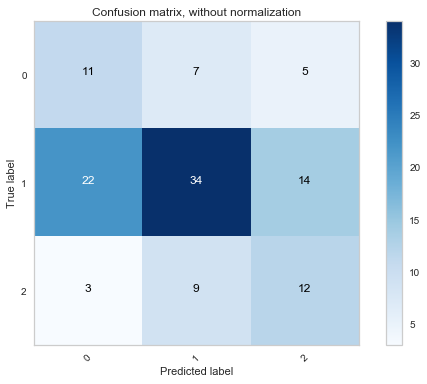

In [61]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_pred =  grid.predict(X_test_t)

cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax = plt.gca()
ax.grid(False)
plot_confusion_matrix(cnf_matrix, classes=targets,
                      title='Confusion matrix, without normalization')

## ARIMA

In [375]:
from statsmodels.tsa.arima_model import ARIMA

df = pd.read_csv('data/prep_temporal_raw.csv', index_col=0)
df = df[~df['mood'].isna()]
df.head()

,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen
id,,,,,,,,,,,,
AS14.01,2014-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,1.0,6.0,NaN
AS14.01,2014-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,6.0,NaN
AS14.01,2014-03-21,0.032787,4.0190,27.7435,17.061,13.6375,52.6750,19.070,0.0,0.0,6.0,32.282
AS14.01,2014-03-22,0.260593,3.8885,20.4580,46.662,10.1160,23.8730,37.305,1.0,1.0,7.0,17.252
AS14.01,2014-03-23,0.139130,3.6045,21.5770,43.178,8.5305,38.1805,NaN,0.0,1.0,7.0,20.311


In [477]:
model_fit.cov_params()
#model_fit.resid()

,const,ar.L1.D.mood,ar.L2.D.mood,ar.L3.D.mood,ar.L4.D.mood,ar.L5.D.mood
const,0.001293,0.000072,0.000254,0.000482,0.000511,0.000322
ar.L1.D.mood,0.000072,0.021617,0.017242,0.010927,0.005044,-0.000325
ar.L2.D.mood,0.000254,0.017242,0.034908,0.026121,0.015245,0.004846
ar.L3.D.mood,0.000482,0.010927,0.026121,0.040306,0.026784,0.010716
ar.L4.D.mood,0.000511,0.005044,0.015245,0.026784,0.036734,0.018621
ar.L5.D.mood,0.000322,-0.000325,0.004846,0.010716,0.018621,0.023219


In [452]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
 
series = pd.read_csv('data/prep_temporal_raw.csv', parse_dates=[1]) # ,  , squeeze=True header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser
# fit model
series = series[series['id']=='AS14.01']
tidx = pd.to_datetime(series['time'].values)
#print(tidx.freq)
#print(tidx.inferred_freq)
#print(tidx)

#series = series[~series['mood'].isna()]
model = ARIMA(endog=series['mood'], order=(5,1,0), dates=pd.DatetimeIndex(tidx.values, freq = tidx.inferred_freq), missing="drop")
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

None
D
DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', '2014-03-06', '2014-03-07', '2014-03-08',
               '2014-03-09', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14', '2014-03-15', '2014-03-16',
               '2014-03-17', '2014-03-18', '2014-03-19', '2014-03-20',
               '2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30', '2014-03-31', '2014-04-01',
               '2014-04-02', '2014-04-03', '2014-04-04', '2014-04-05',
               '2014-04-06', '2014-04-07', '2014-04-08', '2014-04-09',
               '2014-04-10', '2014-04-11', '2014-04-12', '2014-04-13',

ValueError: Length of passed values is 46, index implies 15

In [359]:
def parser(x):
    return datetime.strptime(str(x)[:10], '%Y-%m-%d')
df_mood['time'] = df_mood['time'].apply(lambda x: parser(x))

### make temporal data

In [437]:
agg = Aggregation(df_mood, 'id', 'time', window=5)
agg.formatTimeSpan()
temp_df = agg.getDF()
temp_df_unstack = temp_df.groupby(['id', 'time','variable'])['value'].median().unstack('variable')
temp_df_unstack = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen']]
temp_df_unstack = temp_df_unstack.reset_index(level=1, drop=False)
temp_df_unstack = temp_df_unstack.reset_index()
temp_df_unstack.to_csv(r'data/prep_temporal_raw.csv', index = False, header=True)

In [2]:
temp_df_unstack =  pd.read_csv(r'data/prep_temporal_raw.csv')
temp_df_unstack.head()

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
